
AG-TS provides a robust and easy way to use Chronos through the familiar TimeSeriesPredictor API.

Chronos can be combined with other forecasting models to build accurate ensembles using the "high_quality" and "best_quality" presets.
Alternatively, Chronos can be used as a standalone zero-shot model with presets such as "chronos_small" or "chronos_base".

In [1]:
# We use uv for faster installation
!pip install uv
!uv pip install -q autogluon.timeseries --system
!uv pip uninstall -q torchaudio torchvision torchtext --system # fix incompatible package versions on Colab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 100.6 MB/s eta 0:00:00


In [2]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

Let's work with a subset of the M4 competition data set to see Chronos-tiny in action.

In [3]:
data = TimeSeriesDataFrame(
    "https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_tiny/train.csv"
)
data.head()

target
item_id timestamp                  
H1      1750-01-01 00:00:00   605.0
        1750-01-01 01:00:00   586.0
        1750-01-01 02:00:00   586.0
        1750-01-01 03:00:00   559.0
        1750-01-01 04:00:00   511.0

In [4]:
prediction_length = 24
train_data, test_data = data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data, presets="chronos_tiny",
)

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20241002_004721'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          12
GPU Count:          1
Memory Avail:       50.93 GB / 52.96 GB (96.2%)
Disk Space Avail:   70.19 GB / 112.64 GB (62.3%)
Setting presets to: chronos_tiny

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'tiny'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 13520 rows, 20 ti

Let's use the predict method to generate forecasts, and the plot method to visualize them.

Model not specified in predict, will default to the model with the best validation score: Chronos[tiny]


config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/33.6M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

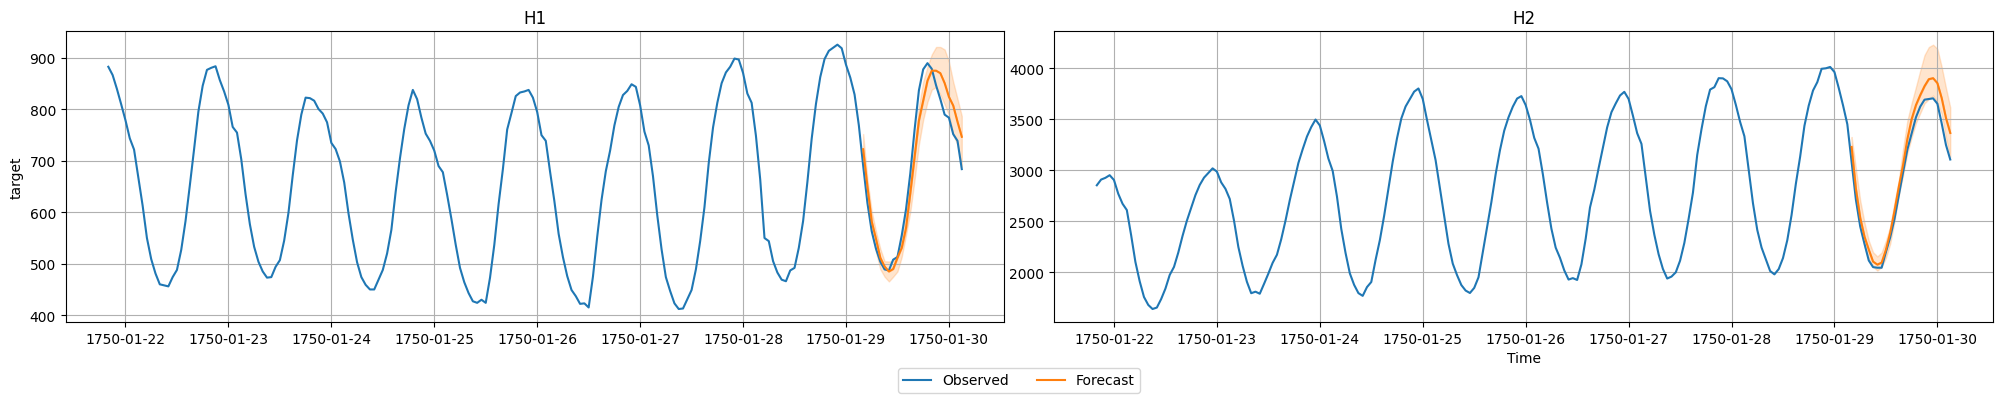

In [5]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=data,
    predictions=predictions,
    item_ids=["H1", "H2"],
    max_history_length=200,
);

### Configuring for Performance
Looks good! As with all large deep learning models, however, some fine-grained control of inference parameters can be needed to both optimize the speed and avoid out-of-memory issues on specific hardware. For this, we will need to dive a bit deeper, configuring hyperparameters of the TimeSeriesPredictor directly.

In [6]:
predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data,
    hyperparameters={
        "Chronos": {
            "model_path": "tiny",
            "batch_size": 64,
            "device": "cpu",
        }
    },
    skip_model_selection=True,
    verbosity=0,
)

In [7]:
%%time
predictions = predictor.predict(train_data)

CPU times: user 32.8 s, sys: 25 s, total: 57.8 s
Wall time: 12.2 s


In [8]:
!pip install -q "autogluon.timeseries[chronos-openvino]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.4/68.4 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 21.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.0/410.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.4/191.4 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 97.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

To speed up the inference even further, we can persist the model after calling fit. The TimeSeriesPredictor.persist method tells AutoGluon to keep the Chronos model in device memory for fast, on-demand inference instead of loading the model from disk each time.

In [9]:
%%capture
predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data,
    hyperparameters={
        "Chronos": {
            "model_path": "tiny",
            "batch_size": 64,
            "device": "cpu",
            "optimization_strategy": "openvino",
        }
    },
    skip_model_selection=True,
    verbosity=0,
)
predictor.persist()

In [10]:
%%time
predictions = predictor.predict(train_data)

CPU times: user 20 s, sys: 3.26 s, total: 23.3 s
Wall time: 3.86 s
